In [84]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Math
import matplotlib.gridspec as gridspec
import time
import pandas
import scipy.stats as st
from astropy.cosmology import FlatLambdaCDM
from scipy.optimize import minimize

In [85]:
def model(x,olambda,omega_m ):
    # print(olambda,omega_m)
    cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda-omega_m )
    x = x[0]
    DL = cosmo.luminosity_distance(x)
    distanceModulus = 5 * np.log10(DL.value)+25
    return distanceModulus

In [86]:
file = pandas.read_csv("supernovaData.csv")
sigma = np.mean(file['sigma'])
data = [file['redshift'],file['modDist']]

In [87]:
x = file['redshift']

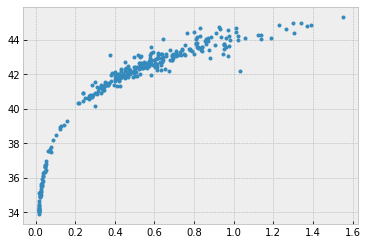

In [88]:
plt.plot(file['redshift'],file['modDist'],'.')

In [89]:
def logprior(theta):
    lp = 0.
    olambda, om = theta
    mmin = 0
    mmax = 1
    lp = 0. if mmin < om < mmax else -np.inf
    lammin = 0
    lammax = 1
    lp += 0. if lammax < olambda < lammin else -np.inf
    
    return lp

In [90]:
def loglike(theta, data, sigma, x):
    olambda, om = theta
    lin_md = model(x,olambda,om)
    like = -0.5 * np.sum(((lin_md - data[1])/sigma)**2)
    return like


In [91]:
def logpost(theta, data, sigma, x):
    return logprior(theta) + loglike(theta, data, sigma, x)

In [92]:
def getSamples(nwalkers):
    theta0 = []
    for j in range(nwalkers): theta0.append(np.abs(np.random.rand())) 
    i = 0
    theta1 = []
    while i<nwalkers:
        val = np.abs(np.random.rand())
        if (1-val-theta0[i]) > 0:
            theta1.append(val)
            i = i + 1
    return np.array([theta0,theta1])


In [93]:

    
def guassian_proposal(theta_curr):
    theta = []
    theta.append(np.abs(np.random.rand())) 
    i = 0
    while i < 1:
        val = np.abs(np.random.rand())
        if (1-val-theta[0]) > 0:
            theta.append(val)
            i += 1
    
    return theta

def guassian_proposal_prob(x1, x2):
    q =  0.07*np.abs(st.norm(loc=x1, scale=1).pdf(x2))
    return q

def mcmc_mh_posterior(X, theta_init,sigma,x,nwalkers,func, proposal_func, proposal_func_prob, n_iter=1000):
    chains = []
    for j in range(nwalkers):
        thetas = []
        theta_curr = theta_init.T[j]
        # print(theta_curr)
        accept_rates = []
        accept_cum = 0
        acceptance_prob = np.array([[0,0]])
        for i in range(1, n_iter+1):
            theta_new = proposal_func(theta_curr)

            prob_curr = func(theta_curr,X,sigma,x)
            # print('theta_new',theta_new)
            prob_new = func(theta_new,X,sigma,x)
            
            if prob_new > prob_curr:
                acceptance_ratio = 1,1
            else:
                qr = proposal_func_prob(theta_curr, theta_new)/proposal_func_prob(theta_curr, theta_new)
                # print('qr',qr)
                acceptance_ratio = np.exp(prob_new - prob_curr) * qr
                
            acceptance_prob = np.append(acceptance_prob,[[min(1, acceptance_ratio[0]),min(1, acceptance_ratio[1])]], axis = 0)

            if acceptance_prob[i][0] > .6*acceptance_prob[i-1][0] and  acceptance_prob[i][0] > .6*acceptance_prob[i-1][1]:
                theta_curr = theta_new
                accept_cum = accept_cum+1
                # print('acc theta_new',theta_new)
                thetas.append(theta_new)
            else:
                thetas.append(theta_curr)
                
            accept_rates.append(accept_cum/i)
        chains.append(thetas)
        
    return chains, accept_rates


X = data
nwalkers = 3
initSamples = getSamples(nwalkers)
thetas, accept_rates = mcmc_mh_posterior(X, initSamples,sigma,x, nwalkers,
                                         logpost, guassian_proposal, guassian_proposal_prob, 
                                         n_iter=1000)


C:\Users\baruc\AppData\Local\Temp\ipykernel_14476\3618947011.py:38: RuntimeWarning: invalid value encountered in double_scalars
  acceptance_ratio = np.exp(prob_new - prob_curr) * qr


In [94]:
m_theta = []
c_theta = []
chains = []
for i in range(nwalkers):
    m_theta = []
    c_theta = []
    for j in range(len(thetas[0])):
        c_theta.append(thetas[i][j][0])
        m_theta.append(thetas[i][j][1])
    chains.append([c_theta,m_theta]) 


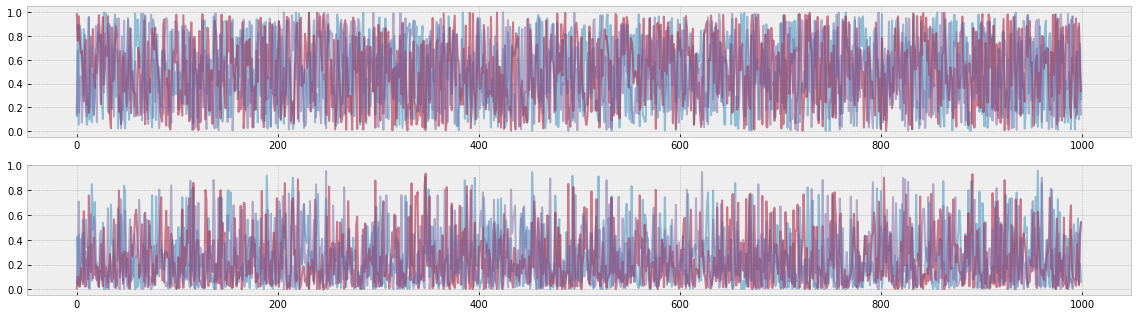

In [95]:


plt.figure(figsize=(16,1.5*nwalkers))

for n in range(ndim):
    plt.subplot2grid((ndim, 1), (n, 0))
    for i in range(nwalkers):
        plt.plot(chains[i][n][:], '-',alpha=0.5)
plt.tight_layout()
plt.show()

In [96]:
import seaborn as sns
import pandas
m = []
c = []
for i in range(len(chains[0][0])):
    meanM = []
    meanC = []
    for j in range(nwalkers):
        meanM.append(chains[j][1][i])
        meanC.append(chains[j][0][i])
    m.append(np.mean(meanM))
    c.append(np.mean(meanC))
m_fit = max(m)
c_fit = max(c) 

d = {'$\Omega_{\Lambda}$': c, '$\Omega_m$': m}
chainData = pandas.DataFrame(d)


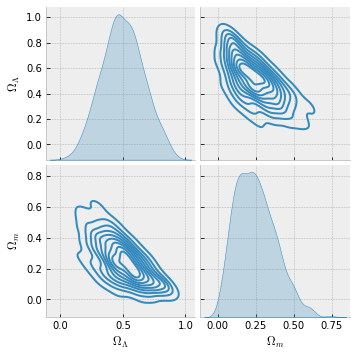

In [97]:
#sns.pairplot(chainData, kind="kde")
plt.style.use('bmh')
g = sns.pairplot(chainData, kind="kde")
i = 0
plt.show()


In [98]:
z=np.linspace(0.01,2,100)
cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - 0.58)
DL = cosmo.luminosity_distance(z) 
mu = 5 * np.log10(DL.value)+25


In [99]:
zchi=np.linspace(0.01,2,100)
def distance_Modulus(z, olambda):
  cosmo =FlatLambdaCDM(H0=67.36, Om0=1. - olambda)
  z = z.tolist()
  DL = cosmo.luminosity_distance(z) 
  distanceModulus = 5 * np.log10(DL.value)+25
  return distanceModulus
def chi2(params):
  olambda=params[0]
  model   = distance_Modulus(file['redshift'].to_numpy(), olambda) 
  return  np.sum((data[1] - model)**2./file['sigma'].to_numpy()**2)
res = minimize(chi2, x0=[0],method='L-BFGS-B', bounds=[(0,0.999)])
muChi = distance_Modulus(file['redshift'],res.x[0])
d = {'redshift':file['redshift'],'muChi':muChi}
muChi = pandas.DataFrame(d)
muChi = muChi.sort_values('muChi',ascending=True)

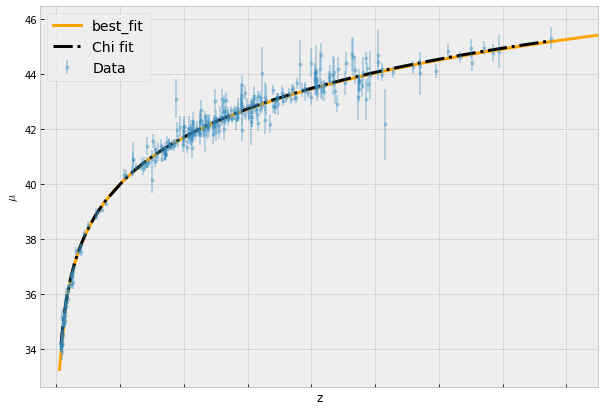

In [100]:
###
fig,ax1=plt.subplots(1,1,figsize=(10,7))
gs=gridspec.GridSpec(1,1)
colors=['b','orange']
###
ax1=plt.subplot(gs[0])


ax1.plot(z,mu, '-',color='orange', lw=3, label='best_fit')
ax1.plot(muChi['redshift'],muChi['muChi'], '-.',color='black', lw=3, label='Chi fit')
ax1.errorbar(file['redshift'],file['modDist'],yerr=file['sigma'].to_numpy(),fmt='.',alpha=0.3,label='Data')
###

ax1.legend(fontsize=14)
ax1.set_xlim(-.05,1.7)
models = ['linear model', 'quadratic model']
ax1.set_ylabel('$\mu$')
ax1.set_xlabel(r'z')
plt.setp(ax1.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)